In [38]:
import numpy as np
import pandas as pd
import sys
import inspect
import numpy as np
import pandas as pd
import sklearn
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler


In [39]:
import os

root_dir = "D:/vhproj/Ton_IoT"
datadir = "data/TON/train_test_network.csv"

path = os.path.join(root_dir, datadir)

print(path)


D:/vhproj/Ton_IoT\data/TON/train_test_network.csv


In [40]:
# Read data and cleaning
df = pd.read_csv(path)
df.replace('-', np.nan, inplace=True)
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

In [41]:
drop_cols = [
    'src_ip', 'dst_ip', 'src_port', 'dst_port',
    'dns_query', 'dns_qclass', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected',
    'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_subject', 'ssl_issuer',
    'http_uri', 'http_version', 'http_user_agent',
    'http_orig_mime_types', 'http_resp_mime_types',
    'weird_addl', 'weird_notice',
    'type'  
]

detect_df = df.drop(columns=drop_cols, errors='ignore')

print(detect_df.columns.tolist())
print(detect_df.shape)
print(df['label'].value_counts())
print(df['type'].value_counts())

['proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_qtype', 'dns_rcode', 'ssl_established', 'http_trans_depth', 'http_method', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'weird_name', 'label']
(211043, 21)
label
1    161043
0     50000
Name: count, dtype: int64
type
normal        50000
backdoor      20000
ddos          20000
dos           20000
injection     20000
password      20000
scanning      20000
ransomware    20000
xss           20000
mitm           1043
Name: count, dtype: int64


In [42]:
# robust_preprocess_and_train.py

print("python:", sys.version.splitlines()[0])
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)

# --- Assumes detect_df already exists in env ---
X = detect_df.drop(columns=['label'])
y = detect_df['label'].astype(int)

# numeric / categorical theo dtype (tránh convert string->float)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# Giảm cardinality để tránh one-hot quá lớn (tùy chỉnh TOP_K)
TOP_K = 50
X_reduced = X.copy()
for col in categorical_cols:
    top_vals = X_reduced[col].value_counts().nlargest(TOP_K).index
    X_reduced[col] = X_reduced[col].where(X_reduced[col].isin(top_vals), other='__OTHER__')

# Kiểm tra unique sau giảm
for col in categorical_cols:
    print(col, "unique after reduction:", X_reduced[col].nunique())

# Tạo OneHotEncoder tương thích nhiều phiên bản sklearn
ohe_kwargs = {}
sig = inspect.signature(OneHotEncoder.__init__)
if 'sparse_output' in sig.parameters:
    ohe_kwargs['sparse_output'] = False
elif 'sparse' in sig.parameters:
    ohe_kwargs['sparse'] = False
else:
    # fallback: no sparse param (very old sklearn) - hope default is dense
    ohe_kwargs = {}

ohe = OneHotEncoder(handle_unknown='ignore', **ohe_kwargs)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, categorical_cols),
        ('num', StandardScaler(), numeric_cols),
    ],
    remainder='drop'
)

# Chia train/test (SMOTE chỉ áp trên train)
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Fit/transform
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print("X_train_prep shape (before SMOTE):", getattr(X_train_prep, "shape", None))
print("X_test_prep shape:", getattr(X_test_prep, "shape", None))

# Cố gắng áp SMOTE; nếu quá tốn bộ nhớ -> fallback sang RandomUnderSampler
try:
    print("Applying SMOTE... (this may use a lot of RAM)")
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_prep, y_train)
    print("After SMOTE class counts:\n", pd.Series(y_train_res).value_counts())

except MemoryError as e:
    print("MemoryError during SMOTE:", e)
    print("Fallback: using RandomUnderSampler (undersample majority class).")
    rus = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train_prep, y_train)
    print("After RandomUnderSampler class counts:\n", pd.Series(y_train_res).value_counts())

except Exception as e:
    # catch other potential errors (e.g. ValueError from sparse/dtype mismatch)
    print("SMOTE failed with exception:", repr(e))
    print("Trying RandomUnderSampler as fallback.")
    rus = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train_prep, y_train)
    print("After RandomUnderSampler class counts:\n", pd.Series(y_train_res).value_counts())




python: 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
scikit-learn: 1.7.2
imbalanced-learn: 0.14.0
Numeric cols: ['duration', 'src_bytes', 'dst_bytes', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_qtype', 'dns_rcode', 'http_request_body_len', 'http_response_body_len', 'http_status_code']
Categorical cols: ['proto', 'service', 'conn_state', 'ssl_established', 'http_trans_depth', 'http_method', 'weird_name']
proto unique after reduction: 3
service unique after reduction: 9
conn_state unique after reduction: 13
ssl_established unique after reduction: 3
http_trans_depth unique after reduction: 11
http_method unique after reduction: 4
weird_name unique after reduction: 11
X_train_prep shape (before SMOTE): (168834, 65)
X_test_prep shape: (42209, 65)
Applying SMOTE... (this may use a lot of RAM)
After SMOTE class counts:
 label
1    128834
0    128834
Name: count, dtype: int64


In [43]:
# Train Linear Regression (như yêu cầu)
lr = LinearRegression()
lr.fit(X_train_res, y_train_res)

# Predict on test set
y_pred_cont = lr.predict(X_test_prep)
y_pred = (y_pred_cont >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8692695870548935
Confusion Matrix:
 [[ 9833   167]
 [ 5351 26858]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.98      0.78     10000
           1       0.99      0.83      0.91     32209

    accuracy                           0.87     42209
   macro avg       0.82      0.91      0.84     42209
weighted avg       0.91      0.87      0.88     42209



--- Train (after SMOTE) — used for training ---
Accuracy: 0.9083  Precision: 0.9813  Recall: 0.8325  F1: 0.9008  ROC-AUC: 0.9698
Confusion matrix:
[[126789   2045]
 [ 21583 107251]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91    128834
           1       0.98      0.83      0.90    128834

    accuracy                           0.91    257668
   macro avg       0.92      0.91      0.91    257668
weighted avg       0.92      0.91      0.91    257668


--- Train (original, no SMOTE) ---
Accuracy: 0.8684  Precision: 0.9942  Recall: 0.8325  F1: 0.9062  ROC-AUC: 0.9699
Confusion matrix:
[[ 39372    628]
 [ 21583 107251]]
Classification report:
              precision    recall  f1-score   support

           0       0.65      0.98      0.78     40000
           1       0.99      0.83      0.91    128834

    accuracy                           0.87    168834
   macro avg       0.82      0.91      0.84    168834
wei

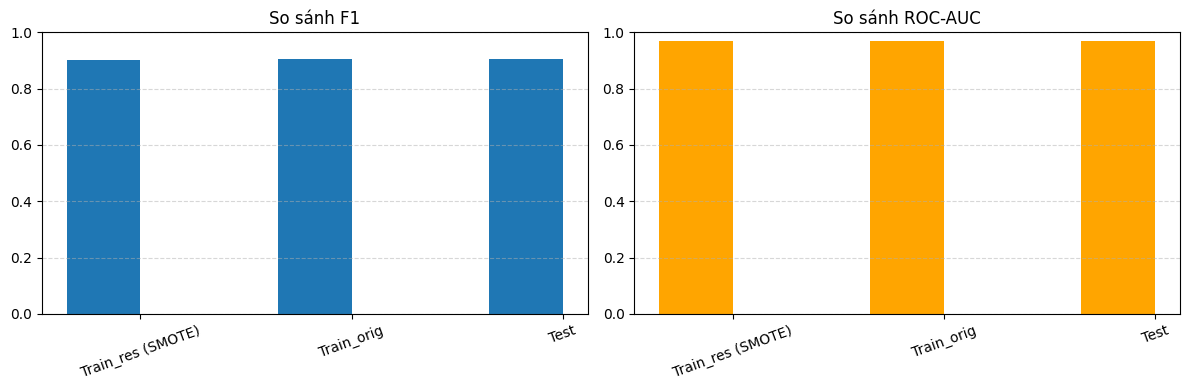

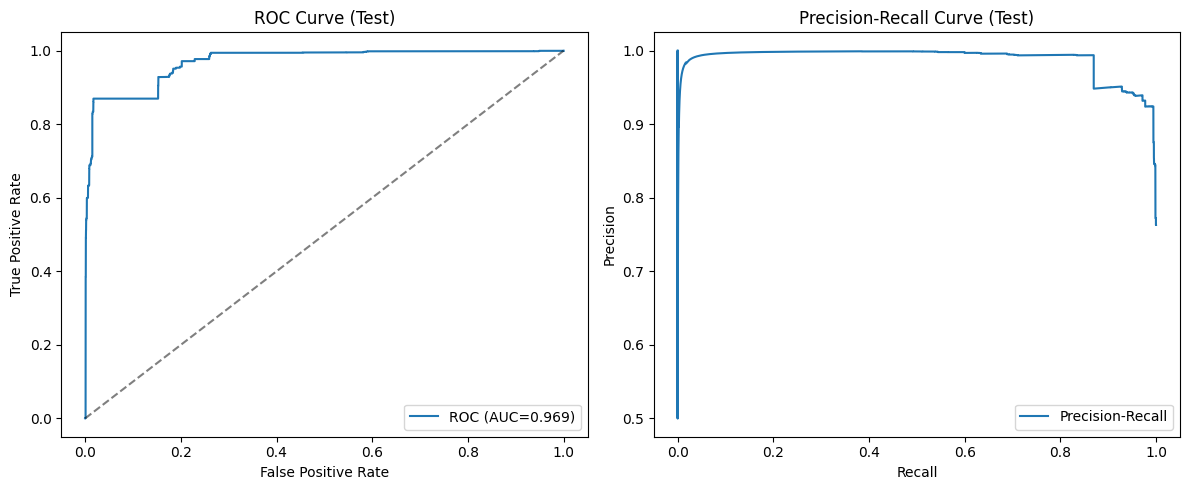

[learning_curve] Training set sizes: [ 15828  51441  87055 122668 158282]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished
c:\Users\firek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
8 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\firek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\firek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1

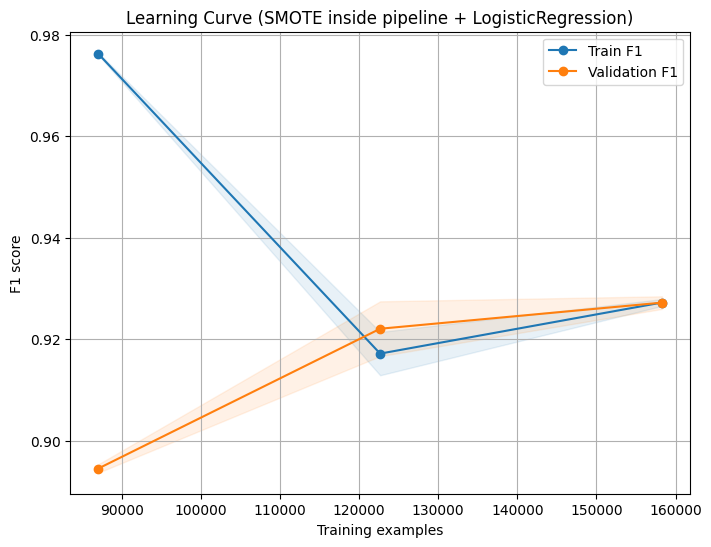


--- Hướng dẫn chẩn đoán ---
1) Nếu F1 trên Train (original hoặc train_res) >> Validation/Test (gap lớn) thì model có khả năng overfit.
2) Nếu train F1 thấp và val F1 thấp -> underfitting.
3) Nếu precision >> recall nhưng bạn cần ít false negative, hãy giảm threshold để tăng recall (tăng FP).
4) Nếu learning curve cho thấy train_score cao, val_score thấp => overfitting. Cần regularize/giảm features/thu nhỏ model/thu thập thêm data.


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.model_selection import learning_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression

# ------- Hàm tiện ích tính & in metrics -------
def evaluate_and_print(name, y_true, scores, threshold=0.5):
    """
    scores: array-like numeric scores (với LinearRegression dùng predict)
    threshold: ngưỡng để chuyển sang nhãn 0/1
    """
    preds = (scores >= threshold).astype(int)
    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    try:
        auc = roc_auc_score(y_true, scores)
    except Exception:
        auc = np.nan

    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {auc:.4f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_true, preds))
    print("Classification report:")
    print(classification_report(y_true, preds, zero_division=0))
    print()
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc, "preds": preds}

# ------- 1) Đánh giá trên train_res (dữ liệu đã SMOTE, model đã train) -------
# Giả sử `lr` đã được fit trên X_train_res, y_train_res (LinearRegression)
# và X_train_prep là X_train đã transform (chưa SMOTE), X_test_prep là test đã transform
# Nếu bạn dùng LinearRegression, dùng lr.predict để có scores.
train_res_scores = lr.predict(X_train_res)            # scores trên dữ liệu đã SMOTE (train used)
train_orig_scores = lr.predict(X_train_prep)         # scores trên train gốc (chưa SMOTE)
test_scores = lr.predict(X_test_prep)                # scores trên test

metrics_train_res = evaluate_and_print("Train (after SMOTE) — used for training", y_train_res, train_res_scores)
metrics_train_orig = evaluate_and_print("Train (original, no SMOTE)", y_train, train_orig_scores)
metrics_test = evaluate_and_print("Test", y_test, test_scores)

# ------- 2) So sánh F1 & AUC giữa các tập (bar chart) -------
labels = ["Train_res (SMOTE)", "Train_orig", "Test"]
f1s = [metrics_train_res["f1"], metrics_train_orig["f1"], metrics_test["f1"]]
aucs = [metrics_train_res["auc"], metrics_train_orig["auc"], metrics_test["auc"]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].bar(x - width/2, f1s, width, label='F1')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, rotation=20)
ax[0].set_title("So sánh F1")
ax[0].set_ylim(0,1)
ax[0].grid(axis='y', linestyle='--', alpha=0.5)

ax[1].bar(x - width/2, aucs, width, label='ROC AUC', color='orange')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, rotation=20)
ax[1].set_title("So sánh ROC-AUC")
ax[1].set_ylim(0,1)
ax[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ------- 3) ROC curve & Precision-Recall curve (Test set) -------
fpr, tpr, _ = roc_curve(y_test, test_scores)
prec, recall_vals, _ = precision_recall_curve(y_test, test_scores)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC (AUC={metrics_test['auc']:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall_vals, prec, label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()

# ------- 4) Learning curve (dùng Pipeline: preprocessor + SMOTE + classifier) -------
# Sử dụng LogisticRegression (classification) để cho learning_curve scoring='f1' dễ dàng
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold

try:
    lc_pipeline = ImbPipeline([
        ('pre', preprocessor),      # ColumnTransformer của bạn
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    train_sizes, train_scores, val_scores = learning_curve(
        lc_pipeline, X_reduced, y, cv=cv, scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, verbose=1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='C0', label="Train F1")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='C0')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='C1', label="Validation F1")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='C1')
    plt.xlabel("Training examples")
    plt.ylabel("F1 score")
    plt.title("Learning Curve (SMOTE inside pipeline + LogisticRegression)")
    plt.legend()
    plt.grid(True)
    plt.show()

except MemoryError:
    print("MemoryError during learning_curve. Try reducing TOP_K or use undersampling.")
except Exception as e:
    print("learning_curve failed:", repr(e))
    print("You can try smaller train_sizes or using RandomUnderSampler in pipeline instead of SMOTE.")

# ------- 5) Hướng dẫn chẩn đoán overfitting -------
print("\n--- Hướng dẫn chẩn đoán ---")
print("1) Nếu F1 trên Train (original hoặc train_res) >> Validation/Test (gap lớn) thì model có khả năng overfit.")
print("2) Nếu train F1 thấp và val F1 thấp -> underfitting.")
print("3) Nếu precision >> recall nhưng bạn cần ít false negative, hãy giảm threshold để tăng recall (tăng FP).")
print("4) Nếu learning curve cho thấy train_score cao, val_score thấp => overfitting. Cần regularize/giảm features/thu nhỏ model/thu thập thêm data.")
